# Multi-resolution Deblending

This tutorial shows how to deblending images taken from different telescopes with different resolutions. In this case we will use a multiband observation with the Hyper-Sprime Cam (HSC) and a single band, high resolution image from teh Hubble Space Telescope (HST). Before using this tutorial you should be familiar with the *scarlet* [User Guide](../user_docs.ipynb) and how to deblend single resolution images.

In [1]:
# Import Packages and setup
import logging

import numpy as np

import scarlet

import scarlet.display
import astropy.io.fits as fits
from astropy.wcs import WCS
from astropy.visualization.lupton_rgb import AsinhMapping, LinearMapping
import sep

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gist_stern')
matplotlib.rc('image', interpolation='none')

## Load and display the sample data

We first load the HSC and HST images, swapping the byte order if necessary because a bug in astropy does not respect the local endianness.

In [2]:
# Load the HSC image data
obs_hdu = fits.open('../../data/test_resampling/Cut_HSC1.fits')
data_hsc = obs_hdu[0].data.byteswap().newbyteorder()
wcs_hsc = WCS(obs_hdu[0].header)
channels_hsc = ['g','r','i','z','y']

# Load the HSC PSF data
psf_hsc = fits.open('../../data/test_resampling/PSF_HSC.fits')[0].data
x,y = np.where(psf_hsc[0]*0==0)
psf_hsc /= psf_hsc.sum(axis=(1,2))[:,None,None]
Np1, Np2 = psf_hsc[0].shape


# Load the HST image data
hst_hdu = fits.open('../../data/test_resampling/Cut_HST1.fits')
data_hst = hst_hdu[0].data
wcs_hst = WCS(hst_hdu[0].header)
channels_hst = ['F814W']

# apply wcs correction
wcs_hst.wcs.crval += 4.4750118475607095e-05*np.array([np.cos(0.4136047623181346 ), np.sin(0.4136047623181346 )])
# Load the HST PSF data
psf_hst = fits.open('../../data/test_resampling/PSF_HST.fits')[0].data
psf_hst = psf_hst[None,2:,2:]
psf_hst /= psf_hst.sum()

# Scale the HST data
n1,n2 = np.shape(data_hst)
data_hst = data_hst.reshape(1, n1, n2).byteswap().newbyteorder()#*np.max(data_hsc)/np.max(data_hst)

r, N1, N2 = data_hsc.shape


Next we have to create a source catalog for the images. Since HST is higher resolution and prone to less blending, we use it for detection but we also run detection on the HSC image to calculate the background RMS:

In [3]:
def makeCatalog(img, lvl = 4):
    if np.size(img.shape) == 3:
        detect = img.mean(axis=0) # simple average for detection
    else:
        detect = img#.byteswap().newbyteorder()
        
    bkg = sep.Background(detect)
    catalog = sep.extract(detect, lvl, err=bkg.globalrms)
    if np.size(img.shape) == 3:
        bg_rms = np.array([sep.Background(band).globalrms for band in img])
    else:
        bg_rms =  sep.Background(detect).globalrms
    return catalog, bg_rms

catalog_hst, bg_rms_hst = makeCatalog(data_hst, 4)
catalog_hsc, bg_rms_hsc = makeCatalog(data_hsc, 4)

Finally we can visualize both the multiband HSC and single band HST images in their native resolutions:

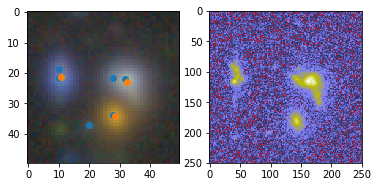

In [4]:
# Create a color mapping for the HSC image
hsc_norm = AsinhMapping(minimum=data_hsc.min(), stretch=data_hsc.max()/20, Q=10)

# Get the source coordinates from the HST catalog
xo,yo = catalog_hst['x'], catalog_hst['y']
xi,yi = catalog_hsc['x'], catalog_hsc['y']
# Convert the HST coordinates to the HSC WCS
ra, dec = wcs_hst.wcs_pix2world(yo,xo,0)
Yo,Xo, l = wcs_hsc.wcs_world2pix(ra, dec, 0, 0)
# Map the HSC image to RGB
img_rgb = scarlet.display.img_to_rgb(data_hsc, norm=hsc_norm)
# Apply Asinh to the HST data
hst_img = np.arcsinh(data_hst[0])

plt.subplot(121)
plt.imshow(img_rgb)
plt.plot(Xo,Yo, 'o')
plt.plot(xi,yi, 'o')
plt.subplot(122)
plt.imshow(hst_img)
plt.show()

## Create the Frame and Observations

Unlike the single resolution examples, we now have two different instruments with different pixel resolutions, so we need two different observations. Since the HST image is at a much higher resolution we define our [Frame](../observation.ipynb#scarlet.observation.Frame) to use the HST PSF in the HST resolution, so our HST observation is a regular [Observation](../observation.ipynb#scarlet.observation.Observation). Since the HSC images need to be upsampled we use the [LowResObservation](../observation.ipynb#scarlet.observation.LowResObservation) class.

In [5]:
# Initialize the frame using the HST PSF and WCS
channels = channels_hsc + channels_hst
shape = (len(channels), n1,n2)
frame = scarlet.Frame(shape, wcs=wcs_hst, psfs=psf_hst, channels=channels)

%time scarlet.LowResObservation(data_hsc,  wcs=wcs_hsc, psfs=psf_hsc, channels=channels_hsc).match(frame)
# define two observation packages and match to frame
obs_hst = scarlet.Observation(data_hst, wcs=wcs_hst, psfs=psf_hst, channels=channels_hst).match(frame)
obs_hsc = scarlet.LowResObservation(data_hsc,  wcs=wcs_hsc, psfs=psf_hsc, channels=channels_hsc).match(frame)

# Keep the order of the observations consistent with the `channels` parameter
# This implementation is a bit of a hack and will be refined in the future
obs = [obs_hsc, obs_hst]

# Set the background levels for both the HSC and HST images
bg_rms = [bg_rms_hsc, bg_rms_hst]

Dtypes of PSFs and Frame different. Casting PSFs to <class 'numpy.float32'>
Dtypes of PSFs and Frame different. Casting PSFs to float64
Dtypes of model and observation different. Casting observation to <class 'numpy.float32'>
Dtypes of PSFs and Frame different. Casting PSFs to float32
Dtypes of PSFs and Frame different. Casting PSFs to float64
Dtypes of model and observation different. Casting observation to <class 'numpy.float32'>


CPU times: user 7.68 s, sys: 2.89 s, total: 10.6 s
Wall time: 10.4 s


## Initialize the Sources

The standard sources discussed in the [User Guide](../user_docs.ipynb#Components-and-Sources) are designed to be initialized with a single dataset. For multi-resolution models we need to use the [CombinedExtendedSource](../source.ipynb#scarlet.source.CombinedExtendedSource) to initialize extended sources by using the morphology from a high resolution observation and the SED from all observations. Because the initialization takes a list of observations, the `obs_idx` argument tells the [CombinedExtendedSource](../source.ipynb#scarlet.source.CombinedExtendedSource) which observation in the list of observations is used to initialize the morphology.

In [6]:
sources = [
    scarlet.CombinedExtendedSource(frame, (ra[i], dec[i]), obs, bg_rms, symmetric=False, monotonic=True, obs_idx=1)
    for i in range(ra.size)
]

## Intialize the blend

The process of initializing a [Blend](../blend.ipynb#scarlet.blend.Blend) with multi-resolution observations is considerably more time consuming that the single resolution version, where the mappings must be created to map from the low resolution to high resolution frame, as well as matching the PSFs in all resolutions.

In [7]:
blend = scarlet.Blend(sources, obs)

## Display the initial guess

Compare the initial guess of the model in both the model frame and HSC observation frame

CPU times: user 1.74 s, sys: 343 ms, total: 2.08 s
Wall time: 479 ms


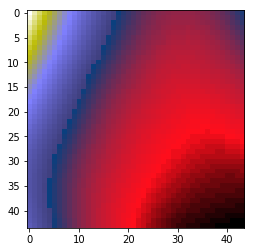

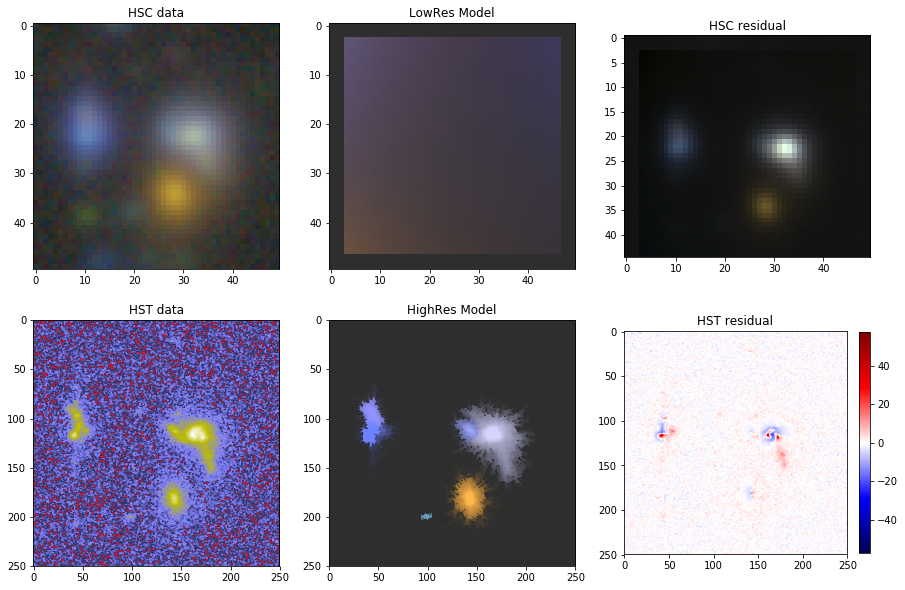

In [13]:
# Load the model and calculate the residual

model = blend.get_model()

%time obs_hsc.render(model)
plt.imshow(obs_hsc._render(model)[1])
plt.show()
model_lr = obs_hsc.render(model)
init_rgb = scarlet.display.img_to_rgb(model[:-1], norm=hsc_norm)
init_rgb_lr = scarlet.display.img_to_rgb(model_lr, norm=hsc_norm)
residual_lr = data_hsc - model_lr
# Trim the bottom source not part of the blend from the image
residual_lr_rgb = scarlet.display.img_to_rgb(residual_lr[:,:-5])

# Get the HR residual
residual_hr = (data_hst - obs_hst.render(model))[0]
vmax = residual_hr.max()

plt.figure(figsize=(15, 10))
plt.subplot(231)
plt.imshow(img_rgb)
plt.title("HSC data")
plt.subplot(235)
plt.imshow(init_rgb)
plt.title("HighRes Model")
plt.subplot(232)
plt.imshow(init_rgb_lr)
plt.title("LowRes Model")
plt.subplot(236)
plt.imshow(residual_hr, cmap="seismic", vmin=-vmax, vmax=vmax)
plt.colorbar(fraction=.045)
plt.title("HST residual")
plt.subplot(233)
plt.imshow(residual_lr_rgb)
plt.title("HSC residual")
plt.subplot(234)
plt.imshow(hst_img)
plt.title('HST data')
plt.show()

## Fit the model

In [ ]:
%time blend.fit(200, e_rel = 1e-3)
print("scarlet ran for {0} iterations".format(blend.it))

### View the full model
First we load the model for the entire blend and its residual. Then we display the model using the same $sinh^{-1}$ stretch as the full image and a linear stretch for the residual to see the improvement from our initial guess.

In [10]:
model = blend.get_model()
model_hr = obs_hst.render(model)
model_lr = obs_hsc.render(model)
rgb = scarlet.display.img_to_rgb(model[:-1], norm=hsc_norm)
rgb_lr = scarlet.display.img_to_rgb(model_lr, norm=hsc_norm)
residual_lr = data_hsc - model_lr*1.5
# Trim the bottom source not part of the blend from the image
residual_lr_rgb = scarlet.display.img_to_rgb(residual_lr[:,:-5], norm=hsc_norm)



# Get the HR residual
residual_hr = (data_hst - model_hr)[0]
vmax = residual_hr.max()

plt.figure(figsize=(15, 10))
plt.subplot(231)
plt.imshow(img_rgb)
plt.title("HSC data")
plt.subplot(235)
plt.imshow(rgb)
plt.title("HST Model")
plt.subplot(232)
plt.imshow(rgb_lr)
plt.title("HSC Model")
plt.subplot(236)
plt.imshow(residual_hr, cmap="seismic", vmin=-vmax, vmax=vmax)
plt.colorbar(fraction=.045)
plt.title("HST residual")
plt.subplot(233)
plt.imshow(residual_lr_rgb)
plt.title("HSC residual")
plt.subplot(234)
plt.imshow(hst_img)
plt.title('HST data')
plt.show()

KeyboardInterrupt: 

### View the source models
It can also be useful to view the model for each source. For each source we extract the portion of the image contained in the sources bounding box, the true simulated source flux, and the model of the source, scaled so that all of the images have roughly the same pixel scale.

In [ ]:
has_truth = False
axes = 2

for k,src in enumerate(blend.sources):
    print('source number ', k)
    # Get the model for a single source
    model = src.get_model()
    model_lr = obs_hsc.render(model)
    
    # Display the low resolution image and residuals
    img_lr_rgb = scarlet.display.img_to_rgb(model_lr, norm = hsc_norm)
    res = data_hsc-model_lr
    res_rgb = scarlet.display.img_to_rgb(res, norm = hsc_norm)
    
    plt.figure(figsize=(15,15))
    
    plt.subplot(331)
    plt.imshow(img_rgb)
    plt.plot(Xo[k],Yo[k], 'x', markersize = 10)
    plt.title("HSC Data")
    plt.subplot(332)
    plt.imshow(img_lr_rgb)
    plt.title("LR Model")
    plt.subplot(333)
    plt.imshow(res_rgb)
    plt.title("LR Data - Model")
    
    img_hr = obs_hst.render(model)
    res = data_hst-img_hr[-1]
    vmax = res.max()
    
    plt.subplot(334)
    plt.imshow(data_hst[0], cmap='gist_stern')
    plt.plot(xo[k],yo[k], 'o', markersize = 5)
    plt.title("HST Data")
    plt.subplot(335)
    plt.imshow(img_hr[-1])
    plt.title("HR Model")
    plt.subplot(336)
    plt.imshow(res[0], cmap='seismic', vmin=-vmax, vmax=vmax)
    plt.title("HR Data - Model")
    
    plt.show()